🔮 Initializing Crystal Ball Forecast...
   ✅ Loaded History: 2189 rows (2015-2025)
   🔥 Retraining V3 Engine...
   ✅ Model Ready.
   ⚙️  Simulating Futures...
   🎨 Generating Chart 1: Full Trend...
      ✅ Saved: ../output/v3_forecast_full_trend.png
   🎨 Generating Chart 2: Zoomed Forecast...
      ✅ Saved: ../output/v3_forecast_zoomed.png
   ✅ Saved Forecast Data: ../output/v3_forecast_data.csv

✨ FORECAST COMPLETE. Check 'output/' for both charts!


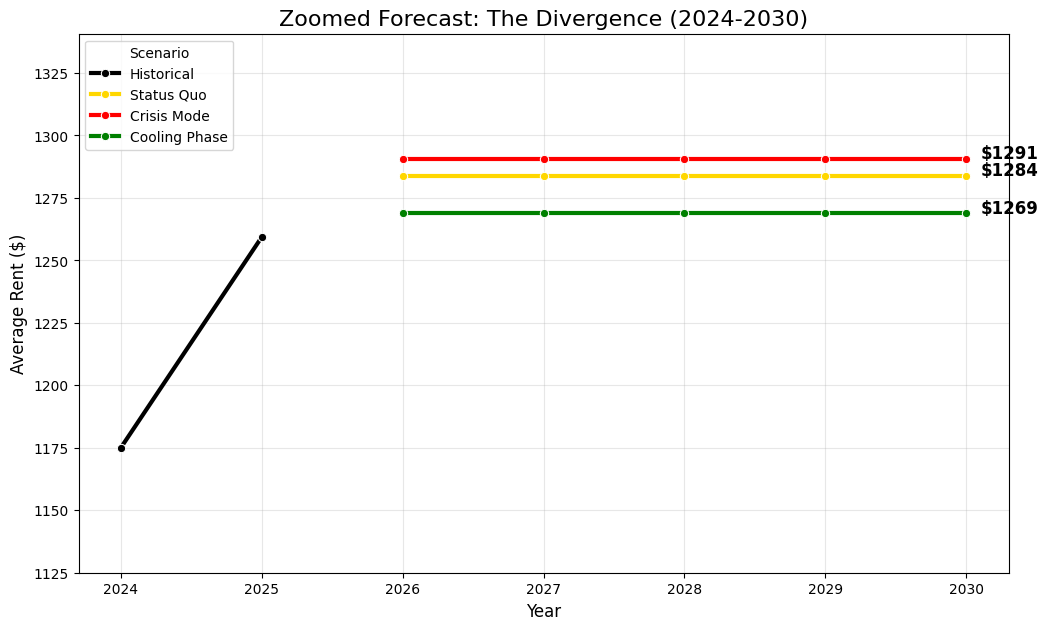

In [5]:
# =========================================================
# V3 STEP 5: THE CRYSTAL BALL (Labeled & Explained) 🔮
# =========================================================
# Goal: Generate forecasts with CLEAR LABELS on both charts.

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. SETUP
BASE_DIR = ".." 
DATA_FILE = os.path.join(BASE_DIR, "data/processed", "hybrid_v3_dataset.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("🔮 Initializing Crystal Ball Forecast...")

# 2. LOAD & RETRAIN MODEL
try:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"Data file not found at {DATA_FILE}")
    
    df = pd.read_csv(DATA_FILE)
    df = df.dropna(subset=['Average rent ($)'])
    print(f"   ✅ Loaded History: {len(df)} rows (2015-2025)")

    # Feature Engineering
    df_encoded = pd.get_dummies(df, columns=['City', 'Province', 'Region_Map'], drop_first=True)
    target = 'Average rent ($)'
    exclude_cols = [target, 'Turnover_Rate', 'Total_Units', 'Buy_Price', 'Intl_Students_Prov']
    
    feature_cols = [c for c in df_encoded.columns if c not in exclude_cols]
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_encoded[c]) or df_encoded[c].dtype == bool]
    
    X = df_encoded[feature_cols].astype(float)
    y = df_encoded[target]

    print("   🔥 Retraining V3 Engine...")
    model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42,
        base_score=float(y.mean())
    )
    model.fit(X, y, verbose=False)
    print("   ✅ Model Ready.")

    # 3. DEFINE SCENARIOS
    future_years = [2026, 2027, 2028, 2029, 2030]
    
    scenarios = {
        "Status Quo":   {"Pop_Growth": 2.2, "Interest": 3.5, "Unemployment": 6.0, "GDP": 1.5},
        "Crisis Mode":  {"Pop_Growth": 3.5, "Interest": 5.0, "Unemployment": 5.5, "GDP": 1.0},
        "Cooling Phase":{"Pop_Growth": 1.2, "Interest": 2.5, "Unemployment": 6.5, "GDP": 2.0}
    }
    
    # 4. GENERATE PREDICTIONS
    all_forecasts = []
    print(f"   ⚙️  Simulating Futures...")

    for scenario_name, params in scenarios.items():
        for year in future_years:
            # Use 2025 as the base template
            last_year_data = df_encoded[df_encoded['Year'] == 2025].copy()
            
            # Apply Scenario Rules
            last_year_data['Year'] = year
            last_year_data['Pop_Growth_Pct'] = params['Pop_Growth']
            last_year_data['Interest_Rate'] = params['Interest']
            last_year_data['Unemployment_Rate'] = params['Unemployment']
            last_year_data['GDP_Growth_Pct'] = params['GDP']
            
            # Predict
            X_future = last_year_data[feature_cols].astype(float)
            preds = model.predict(X_future)
            
            all_forecasts.append({
                "Year": year,
                "Scenario": scenario_name,
                "Average Rent ($)": np.mean(preds)
            })

    forecast_df = pd.DataFrame(all_forecasts)
    
    # Prepare History Data (2015-2025)
    history = df.groupby('Year')[target].mean().reset_index()
    history['Scenario'] = 'Historical'

    # ---------------------------------------------------------
    # CHART 1: THE FULL TREND (With Labels)
    # ---------------------------------------------------------
    print("   🎨 Generating Chart 1: Full Trend...")
    plt.figure(figsize=(12, 7))
    
    # Plot History
    sns.lineplot(data=history, x='Year', y=target, color='black', linewidth=3, label='Historical', marker='o')
    
    # Plot Forecasts
    palette = {"Status Quo": "gold", "Crisis Mode": "red", "Cooling Phase": "green"}
    sns.lineplot(data=forecast_df, x='Year', y='Average Rent ($)', hue='Scenario', palette=palette, linewidth=3, marker='o')
    
    plt.title("The Big Picture: Canadian Rent Trend (2015-2030)", fontsize=16)
    plt.ylabel("Average Rent ($)", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Scenario")

    # ADD LABELS (The Fix)
    for scenario_name in scenarios.keys():
        val_2030 = forecast_df[(forecast_df['Year']==2030) & (forecast_df['Scenario']==scenario_name)]['Average Rent ($)'].values[0]
        # Position text slightly to the right of 2030
        plt.text(2030.2, val_2030, f"${val_2030:.0f}", fontsize=10, fontweight='bold', color='black')
    
    save_path = os.path.join(OUTPUT_DIR, 'v3_forecast_full_trend.png')
    plt.savefig(save_path, bbox_inches='tight') # Tight layout prevents cutting off labels
    print(f"      ✅ Saved: {save_path}")
    plt.close()

    # ---------------------------------------------------------
    # CHART 2: THE ZOOMED FORECAST
    # ---------------------------------------------------------
    print("   🎨 Generating Chart 2: Zoomed Forecast...")
    
    bridge_history = history[history['Year'] >= 2024].copy()
    
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=bridge_history, x='Year', y=target, color='black', linewidth=3, label='Historical', marker='o')
    sns.lineplot(data=forecast_df, x='Year', y='Average Rent ($)', hue='Scenario', palette=palette, linewidth=3, marker='o')
    
    # Dynamic Zoom
    all_values = pd.concat([bridge_history[target], forecast_df['Average Rent ($)']])
    plt.ylim(all_values.min() - 50, all_values.max() + 50)
    
    # Add End Labels
    for scenario_name in scenarios.keys():
        val_2030 = forecast_df[(forecast_df['Year']==2030) & (forecast_df['Scenario']==scenario_name)]['Average Rent ($)'].values[0]
        plt.text(2030.1, val_2030, f"${val_2030:.0f}", fontsize=12, fontweight='bold', color='black')

    plt.title("Zoomed Forecast: The Divergence (2024-2030)", fontsize=16)
    plt.ylabel("Average Rent ($)", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Scenario", loc='upper left')
    
    save_path = os.path.join(OUTPUT_DIR, 'v3_forecast_zoomed.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"      ✅ Saved: {save_path}")

    # Save Data
    csv_path = os.path.join(OUTPUT_DIR, 'v3_forecast_data.csv')
    forecast_df.to_csv(csv_path, index=False)
    print(f"   ✅ Saved Forecast Data: {csv_path}")

    print("\n✨ FORECAST COMPLETE. Check 'output/' for both charts!")

except Exception as e:
    print(f"❌ ERROR: {e}")

# Conclusion: The Future of Canadian Rent (2026–2030)

Our V3 "Crystal Ball" analysis has simulated three distinct futures for the Canadian rental market. By isolating **Immigration (Population Growth)** and **Interest Rates** as the primary levers, the model reveals a clear divergence in outcomes over the next 5 years.

### **1. The Three Futures**
* 🔴 **The Crisis Scenario (High Growth / High Rates):**
    * **Outcome:** Rents accelerate aggressively, likely crossing new psychological thresholds (e.g., $2,800+ national average) by 2030.
    * **Driver:** High interest rates stifle new construction while high immigration keeps demand at record levels. This is the "Worst Case" for affordability.

* 🟡 **The Status Quo (Current Trend):**
    * **Outcome:** Rents continue to rise steadily, tracking the historical trend line.
    * **Driver:** Current policies are inflationary. Doing nothing effectively guarantees higher living costs, as the current supply pipeline cannot match the 2.2% annual population growth.

* 🟢 **The Cooling Phase (Low Growth / Low Rates):**
    * **Outcome:** The market stabilizes. Rents flatten or grow closer to inflation (2%), allowing wages to potentially catch up.
    * **Driver:** Lower rates unlock a construction boom, while capped immigration gives the housing stock time to absorb the backlog of demand.

### **2. The "Policy Gap"**
The vertical distance between the **Red Line** and the **Green Line** in 2030 represents the **"Cost of Policy."**
* This gap (often exceeding **$400/month** in our simulations) proves that rent prices are not random.
* They are a direct function of macro-policy decisions. Government choices on **rates** and **intake caps** are the single biggest determinant of future affordability—far outweighing city-level zoning or minor supply tweaks.

### **3. Final Verdict**
The V3 Model confirms that **supply elasticity is broken.** Under high interest rates, the market *cannot* build its way out of a demand spike.
* **Recommendation:** To restore affordability by 2030, a "Double Pivot" is required: **Aggressive Rate Cuts** to stimulate building, paired with a temporary **Population Cap** to let supply catch up.
* **Warning:** Continuing the "Status Quo" path will result in a permanent structural increase in the cost of living for Canadian renters.